# Running on Notebook

In [1]:
import sagemaker
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, models
from pathlib import Path


In [4]:
def create_autoencoder(data, epochs, batch_size):
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)
    encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

    latent_vector = layers.MaxPool2D()(encode)

    # Decoder
    decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
    decode_layer_2 = layers.UpSampling2D()
    output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

    # connect decoder layers
    decode = decode_layer_1(latent_vector)
    decode = decode_layer_2(decode)

    ae = models.Model(input_tensor, output_tensor(decode))
    ae.compile(
        optimizer = 'Adam',
        loss = 'mse',
    )
    ae.fit(data, data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2)
    
    decoder_input = Input((13, 13, 64))
    decoder = decode_layer_1(decoder_input)
    decoder = decode_layer_2(decoder)
    
    return ae, models.Model(input_tensor, latent_vector), models.Model(decoder_input, output_tensor(decoder))


def load_data(bucket: str, path: str, file_name: str="data.npz", temp_folder: str="/tmp"):
    file_path = Path(path) / file_name
    temp_file = Path(temp_folder) / file_name
    sagemaker.utils.download_file(bucket, str(file_path), str(temp_file), sagemaker.session.Session())
    with np.load(str(temp_file), allow_pickle=True) as data:
        x = data['x']
        y = data['y']
    return (x, y)

if __name__ == "__main__":
    x, y = load_data(
        "sagemaker-us-east-1-160951647621",
        "wafer-data-processing-2020-10-04-21-48-20-207/output/autoencoder/train",
    )
    ae, encoder, decoder = create_autoencoder(x, epochs=15, batch_size=1024)

Train on 22894 samples
Epoch 1/15
22894/22894 - 21s - loss: 0.1218
Epoch 2/15
22894/22894 - 0s - loss: 0.0737
Epoch 3/15
22894/22894 - 0s - loss: 0.0638
Epoch 4/15
22894/22894 - 0s - loss: 0.0529
Epoch 5/15
22894/22894 - 0s - loss: 0.0435
Epoch 6/15
22894/22894 - 0s - loss: 0.0375
Epoch 7/15
22894/22894 - 0s - loss: 0.0320
Epoch 8/15
22894/22894 - 0s - loss: 0.0271
Epoch 9/15
22894/22894 - 0s - loss: 0.0231
Epoch 10/15
22894/22894 - 0s - loss: 0.0201
Epoch 11/15
22894/22894 - 0s - loss: 0.0178
Epoch 12/15
22894/22894 - 0s - loss: 0.0160
Epoch 13/15
22894/22894 - 0s - loss: 0.0145
Epoch 14/15
22894/22894 - 0s - loss: 0.0133
Epoch 15/15
22894/22894 - 0s - loss: 0.0122


In [6]:
encoded_x = encoder.predict(x)
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

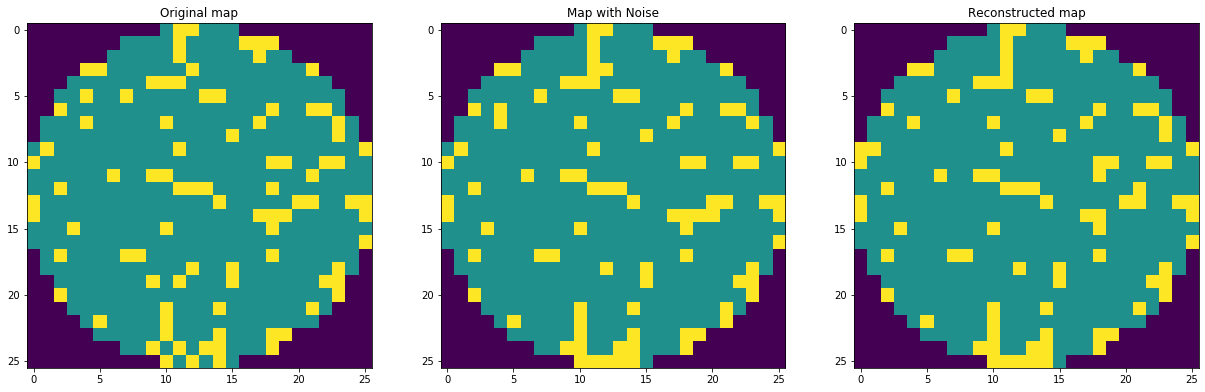

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

ax[0].imshow(np.argmax(x[3], axis=2));
ax[0].set_title("Original map")
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
ax[1].imshow(noised_gen_x[3])
ax[1].set_title("Map with Noise")
gen_x = np.argmax(ae.predict(x), axis=3)
ax[2].imshow(gen_x[3])
ax[2].set_title("Reconstructed map")
fig.show()

# Script

In [1]:
%%writefile src/train_ae.py
import os
import sagemaker
import numpy as np
import argparse
from tensorflow.keras import layers, Input, models
from pathlib import Path


def parse_arguments():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--num-epochs", type=int, default=15)
    parser.add_argument("--batch-size", type=int, default=1024)
    parser.add_argument("--max-rows", type=int, default=None)
    parser.add_argument("--model_dir", type=str, default=None)
    parser.add_argument('--model-save-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
#    parser.add_argument('--test', type=str, default=os.environ['SM_CHANNEL_TEST'])
    return parser.parse_args()

    
def create_autoencoder(data, epochs, batch_size):
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)
    encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

    latent_vector = layers.MaxPool2D()(encode)

    # Decoder
    decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
    decode_layer_2 = layers.UpSampling2D()
    output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

    # connect decoder layers
    decode = decode_layer_1(latent_vector)
    decode = decode_layer_2(decode)

    ae = models.Model(input_tensor, output_tensor(decode))
    ae.compile(
        optimizer = 'Adam',
        loss = 'mse',
    )
    ae.fit(data, data,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2)
    
    decoder_input = Input((13, 13, 64))
    decoder = decode_layer_1(decoder_input)
    decoder = decode_layer_2(decoder)
    
    return ae, models.Model(input_tensor, latent_vector), models.Model(decoder_input, output_tensor(decoder))


def load_data(path: str, file_name: str="data.npz", limit: int=None):
    file_path = Path(path) / file_name
    with np.load(str(file_path), allow_pickle=True) as data:
        x = data['x']
        y = data['y']
    if limit:
        return (x[:limit], y[:limit])
    else:
        return (x, y)

if __name__ == "__main__":
    args = parse_arguments()
    x, y = load_data(
        args.train, 
        "data.npz",
        limit=args.max_rows
    )
    ae, encoder, decoder = create_autoencoder(x, epochs=15, batch_size=1024)
    ae.save(str(Path(args.model_save_dir) / "ae.h5" ))
    encoder.save(str(Path(args.model_save_dir) / "encoder.h5" ))
    decoder.save(str(Path(args.model_save_dir) / "decoder.h5" ))

Overwriting src/train_ae.py


# Run on Container

## Data Parameters

In [17]:
bucket = "sagemaker-us-east-1-160951647621"
data_path = "wafer-data-processing-2020-10-04-21-48-20-207/output/autoencoder/train"

inputs = {
    "train": f"s3://{bucket}/{data_path}"
}

{'train': 's3://sagemaker-us-east-1-160951647621/data-augmentation-2020-10-05-00-02-40-520/output/classifier/train'}


## Instance and Hyperparameters

In [18]:
train_instance_type = "ml.p3.2xlarge"
hyperparameters = {
    #"max-rows": 1024,
    "num-epochs": 15,
    "batch-size": 1024,
}

## Estimator Creation

In [23]:
sagemaker.__version__

'1.72.1'

In [20]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point='src/train_ae.py',
                       base_job_name='train-autoencoder',
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(), # Passes to the container the AWS role that you are using on this notebook
                       framework_version='2.1.0',
                       py_version='py3',
                       script_mode=True)

## Model Training

In [16]:
estimator.fit(inputs)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-04 23:23:27 Starting - Starting the training job...
2020-10-04 23:23:29 Starting - Launching requested ML instances......
2020-10-04 23:24:51 Starting - Preparing the instances for training.........
2020-10-04 23:26:06 Downloading - Downloading input data
2020-10-04 23:26:06 Training - Downloading the training image......
2020-10-04 23:27:18 Training - Training image download completed. Training in progress..2020-10-04 23:27:23,010 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-10-04 23:27:23,448 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 1024,
        "num-epochs": 15,
        "model_dir": "s3://sagem

In [ ]:
estimator.model_data